In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *
DATA_DIR = '/work/users/k/4/k4thryn/Repos/OLD_EpSampling_Nov2024/data/'

### Functions

In [2]:
def get_model_df(df, X_COLS, Y_COL, NAIVE_COL):
    cols = ['Date', 'Fips'] + X_COLS + [Y_COL, NAIVE_COL]
    df = df[cols]    
    return df

#### #### #### #### #### #### #### #### #### #### ####
#### #### #### #### #### #### #### #### #### #### ####

from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.model_selection import train_test_split

def get_df_res(df_train, df_test, X_COLS, Y_COL, PRED_COL, ALG):    
    X_train = df_train[X_COLS]
    y_train = df_train[Y_COL]
    X_test = df_test[X_COLS]
    
    df_pred = df_test.copy()
    reg = linear_model.LinearRegression().fit(X_train, y_train)
    df_pred['Algorithm'] = ALG
    df_pred[PRED_COL] = reg.predict(X_test)
    
    return df_pred

# <font color=blue> 1) Dataset

In [3]:
ts = '20241108-123515'
fpath = os.path.join(DATA_DIR,'processed',f'training_target_df_{ts}.csv')
dff = pd.read_csv(fpath)

pd.set_option('display.max_columns', None)

# print(dff.columns)
# display(dff)
d = {'Proj_state_inc_deaths':'PROJ state deaths',
     'True_county_inc_deaths':'TRUE county deaths',
     'Pop':'County population',
     'Naive_proj_deaths':'Naive PROJ deaths',
    }

dff.rename(d,axis=1,inplace=True)

Y_COL = 'TRUE county deaths'
X_COLS = ['PROJ state deaths','County population']
NAIVE_COL = 'Naive PROJ deaths'

dff.dropna(inplace=True)
df = dff[dff[Y_COL] >= 0]

In [4]:
df = get_model_df(df, X_COLS, Y_COL, NAIVE_COL)
display(df)

,Date,Fips,PROJ state deaths,County population,TRUE county deaths,Naive PROJ deaths
11,20200905,37001,157.0,169185,0.0,2.562167
12,20200912,37001,176.0,169185,2.0,2.872239
13,20200919,37001,157.0,169185,0.0,2.562167
14,20200926,37001,171.0,169185,6.0,2.790641
15,20201003,37001,171.0,169185,2.0,2.790641
...,...,...,...,...,...,...
9895,20220409,37199,55.0,18357,0.0,0.097389
9896,20220416,37199,41.0,18357,0.0,0.072599
9897,20220423,37199,60.0,18357,0.0,0.106243
9898,20220430,37199,33.0,18357,0.0,0.058433


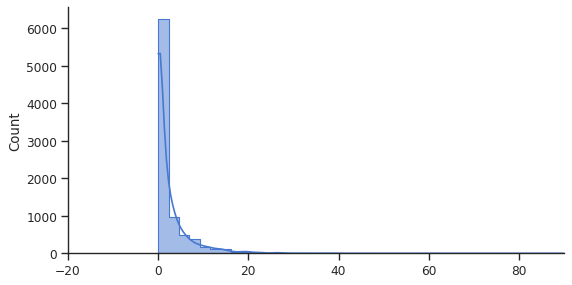

Are all targets non-negative? True


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='muted') 
DPI = 80
FIGSIZE = (8,4)

plt.figure(figsize=FIGSIZE)
sns.histplot(df[Y_COL].values, bins=40, kde=True, element='step')
sns.despine()
plt.xlim((-20, 90))
plt.gcf().set_dpi(DPI)
plt.show()

print(f"Are all targets non-negative? {(df[Y_COL].min() >= 0)}")

## <font color=blue> 2) Training: County population + Predicted state deaths

    
<font color=blue> _Compare regression algorithms:_
1. <font color=blue>  Linear 
1. <font color=blue>  Poisson 
1. <font color=blue>  Zero-inflated
    
This is our most simplistic model. We are predicting the number of county deaths given two covariates: 1) projected state deaths (from COVIDHub) and 2) county population. We will consider vanilla linear regression, poisson regression, and zero-inflated regression.

### <font color=blue> Model design
- <font color=blue> **_Train-test split:_** Our training and test/evaluation set will be partitioned based on (2 month)-wise chunks. That is, we will evaluate our model on temporally consecutive targets over the course of 8 weeks, and we will train on the remaining weeks.
    - <font color=black> **Train samps:** 7939
    - <font color=black> **Test samps:** 771
- <font color=blue> **_Cross validation protocol:_** We will train a model for each month, for a total of 10 models. From these, we can evaluate average performance for each regression algorithm.
    

In [6]:
ALG = 'Linear Regression'

res_dfs = []
models = {}
chunks = get_chunks(list(df.Date.unique()), num_membs=8)

for i,test_chunk in enumerate(chunks):
    
    df_train, df_test = get_date_chunked_splits(df, chunks, i)
    df_test[f'Run'] = i
    
    PRED_COL = 'PRED county deaths'
    df_res = get_df_res(df_train, df_test, X_COLS, Y_COL, PRED_COL, ALG)
    
    if i==0: display(df_test.head(), df_res.head())
        
    res_dfs.append(df_res)
    
df_full_res = pd.concat(res_dfs)

,Date,Fips,PROJ state deaths,County population,TRUE county deaths,Naive PROJ deaths,Run
11,20200905,37001,157.0,169185,0.0,2.562167,0
12,20200912,37001,176.0,169185,2.0,2.872239,0
13,20200919,37001,157.0,169185,0.0,2.562167,0
14,20200926,37001,171.0,169185,6.0,2.790641,0
15,20201003,37001,171.0,169185,2.0,2.790641,0


,Date,Fips,PROJ state deaths,County population,TRUE county deaths,Naive PROJ deaths,Run,Algorithm,PRED county deaths
11,20200905,37001,157.0,169185,0.0,2.562167,0,Linear Regression,2.780902
12,20200912,37001,176.0,169185,2.0,2.872239,0,Linear Regression,2.943351
13,20200919,37001,157.0,169185,0.0,2.562167,0,Linear Regression,2.780902
14,20200926,37001,171.0,169185,6.0,2.790641,0,Linear Regression,2.900601
15,20201003,37001,171.0,169185,2.0,2.790641,0,Linear Regression,2.900601


In [7]:
df_full_res

,Date,Fips,PROJ state deaths,County population,TRUE county deaths,Naive PROJ deaths,Run,Algorithm,PRED county deaths
11,20200905,37001,157.0,169185,0.0,2.562167,0,Linear Regression,2.780902
12,20200912,37001,176.0,169185,2.0,2.872239,0,Linear Regression,2.943351
13,20200919,37001,157.0,169185,0.0,2.562167,0,Linear Regression,2.780902
14,20200926,37001,171.0,169185,6.0,2.790641,0,Linear Regression,2.900601
15,20201003,37001,171.0,169185,2.0,2.790641,0,Linear Regression,2.900601
...,...,...,...,...,...,...,...,...,...
9895,20220409,37199,55.0,18357,0.0,0.097389,10,Linear Regression,-0.493323
9896,20220416,37199,41.0,18357,0.0,0.072599,10,Linear Regression,-0.626466
9897,20220423,37199,60.0,18357,0.0,0.106243,10,Linear Regression,-0.445772
9898,20220430,37199,33.0,18357,0.0,0.058433,10,Linear Regression,-0.702548


## <font color=blue> 3) Evaluation

## <font color=blue> a. _Metrics_ 
Average across cross-validation splits.

In [8]:
## GET PERFORMANCE !
# from epsampling.modeling import get_metrics_ser

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

def get_metrics_ser(df, target_col, pred_col, alg_col, naive_col):
    
    metrics_dict = {'MAE': mean_absolute_error,
                    'MedAE': median_absolute_error,
                    'MSE': mean_squared_error,
                    'RMSE': mean_squared_error,
                    'r2': r2_score
                    }
    
    mae = mean_absolute_error(df[target_col], df[pred_col])
    medae = median_absolute_error(df[target_col], df[pred_col])
    r2 = r2_score(df[target_col], df[pred_col])
    mse = mean_squared_error(df[target_col], df[pred_col])
    
    relmae = mae / mean_absolute_error(df[target_col],df[naive_col])
    
    ser = {'Algorithm':alg_col, 'MAE':mae, 'MedAE':medae, 
           'R-squared':r2, 'MSE': mse, 'relMAE': relmae,}
    
    return ser
    

metric_sers = []

for run in df_full_res.Run.unique():
    
    subdf = df_full_res[df_full_res['Run']==run]
    ser = get_metrics_ser(subdf, 
                          target_col=Y_COL,
                          pred_col=PRED_COL,
                          alg_col=ALG,
                          naive_col=NAIVE_COL)
    
    metric_sers.append(ser)
    
df_run = pd.DataFrame(metric_sers)
df_run

,Algorithm,MAE,MedAE,R-squared,MSE,relMAE
0,Linear Regression,1.627032,1.003222,0.169491,6.644707,1.026191
1,Linear Regression,2.009419,1.397554,0.331213,9.546241,0.999110
2,Linear Regression,4.272533,3.018817,0.270020,45.312844,1.168905
3,Linear Regression,2.075019,1.412254,0.365541,15.632465,1.134617
4,Linear Regression,1.340632,0.663460,-0.042497,6.551258,1.154889
5,Linear Regression,1.178817,0.469826,-0.915818,5.980194,1.426485
6,Linear Regression,2.938983,2.110605,0.315842,20.835374,1.063743
7,Linear Regression,2.201704,1.520520,0.201092,17.872938,1.008179
8,Linear Regression,1.779726,1.074723,0.301836,7.886065,1.102015
9,Linear Regression,3.037473,2.247425,0.347512,18.867067,1.132506


In [9]:
df_melt = pd.melt(df_run, id_vars=['Algorithm'], 
                  value_vars=['MAE', 'MedAE', 'R-squared','MSE','relMAE'], 
                  var_name='Metric', value_name='Score')

# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set(font_scale=1, style='whitegrid', palette='pastel') 

# DPI = 80

# for metric in df_melt.Metric.unique():
#     df_plot = df_melt[df_melt.Metric==metric]
# #     display(df_plot)
#     sns.boxplot(df_plot, x='Algorithm',y='Score')   
#     plt.title(f'{metric}')
#     plt.xticks(rotation=45,ha='right')
#     plt.gcf().set_dpi(DPI)
#     plt.show()

# df_full_res

for metric in  ['MAE', 'MedAE', 'R-squared', 'MSE'    ,'relMAE']:
    dff_melt = df_melt[df_melt['Metric']==metric]
    print(f'\n* {metric} *  \n Mean: {round(dff_melt.Score.mean(),3)}\n Median: {round(dff_melt.Score.median(),3)}')


* MAE *  
 Mean: 2.267
 Median: 2.075

* MedAE *  
 Mean: 1.418
 Median: 1.398

* R-squared *  
 Mean: 0.123
 Median: 0.27

* MSE *  
 Mean: 17.699
 Median: 15.632

* relMAE *  
 Mean: 1.125
 Median: 1.133


## <font color=blue> b. _Plots_

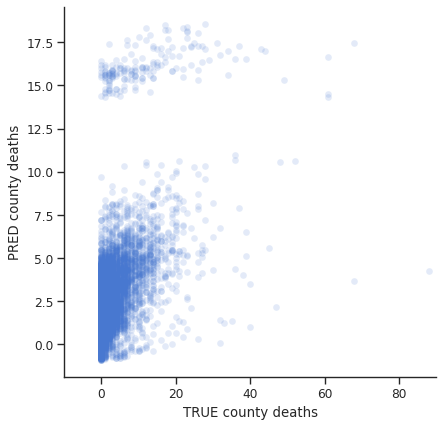

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='muted') 

figsize = (8,6)
alpha = 0.15
sizes = 2
linewidth = 0

DPI = 80
FIGSIZE = (6,6)

# df = df_pred

plt.figure(figsize=FIGSIZE)
sns.scatterplot(data=df_full_res, x=Y_COL, y=PRED_COL, alpha=alpha, sizes=sizes, linewidth=linewidth)
sns.despine()
plt.xlim((-10, 90))
plt.gcf().set_dpi(DPI)
plt.show()


# figsize = (8,6)
# alpha = 0.15
# sizes = 2
# linewidth = 0

# sns.regplot(data=df_full_res,  x=Y_COL, y=PRED_COL,
#             scatter_kws={'s':10, 'alpha':0.5}, line_kws={'color':'k','linewidth':1})
# sns.despine()
# plt.title('raw') 
# plt.title('y+(1)/pop*100000\n r2: 0.934336') 
# plt.title('y/pop*100000\n r2: -0.016382') 

# plt.show()

# <font color=red> What about when transformed?